
# Transfer Learning on Oxford Flowers 102 Dataset

## Objective
Apply transfer learning techniques using pre-trained convolutional neural networks to classify images from the Oxford Flowers 102 dataset.

## Models Used
- ResNet50
- VGG16
- MobileNetV2
- Xception
- InceptionV3
- EfficientNetB0

## Dataset
**Oxford Flowers 102**: A dataset containing 102 categories of flowers commonly found in the UK. Each class consists of between 40 and 258 images with significant scale, pose, and light variations.

## Approach
1. Load and preprocess the dataset
2. Apply transfer learning with frozen base models
3. Fine-tune top layers for improved performance
4. Evaluate and compare model performances
"""

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

# Import preprocessing functions for each model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inceptionv3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnetb0

# Import model architectures
from tensorflow.keras.applications import (
    ResNet50, VGG16, MobileNetV2,
    Xception, InceptionV3, EfficientNetB0
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))






TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data Loading and Exploration

We'll load the Oxford Flowers 102 dataset using TensorFlow Datasets (TFDS). The dataset is split into:
- **Training set**: 1,020 images
- **Validation set**: 1,020 images
- **Test set**: 6,149 images
"""

In [4]:

# Load the Oxford Flowers 102 dataset
(train_ds, val_ds, test_ds), info = tfds.load(
    'oxford_flowers102:2.1.1',
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True
)

NUM_CLASSES = info.features['label'].num_classes
BATCH_SIZE = 32

print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {info.splits['train'].num_examples}")
print(f"Validation samples: {info.splits['validation'].num_examples}")
print(f"Test samples: {info.splits['test'].num_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4D6GW7_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4D6GW7_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4D6GW7_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Number of classes: 102
Training samples: 1020
Validation samples: 1020
Test samples: 6149


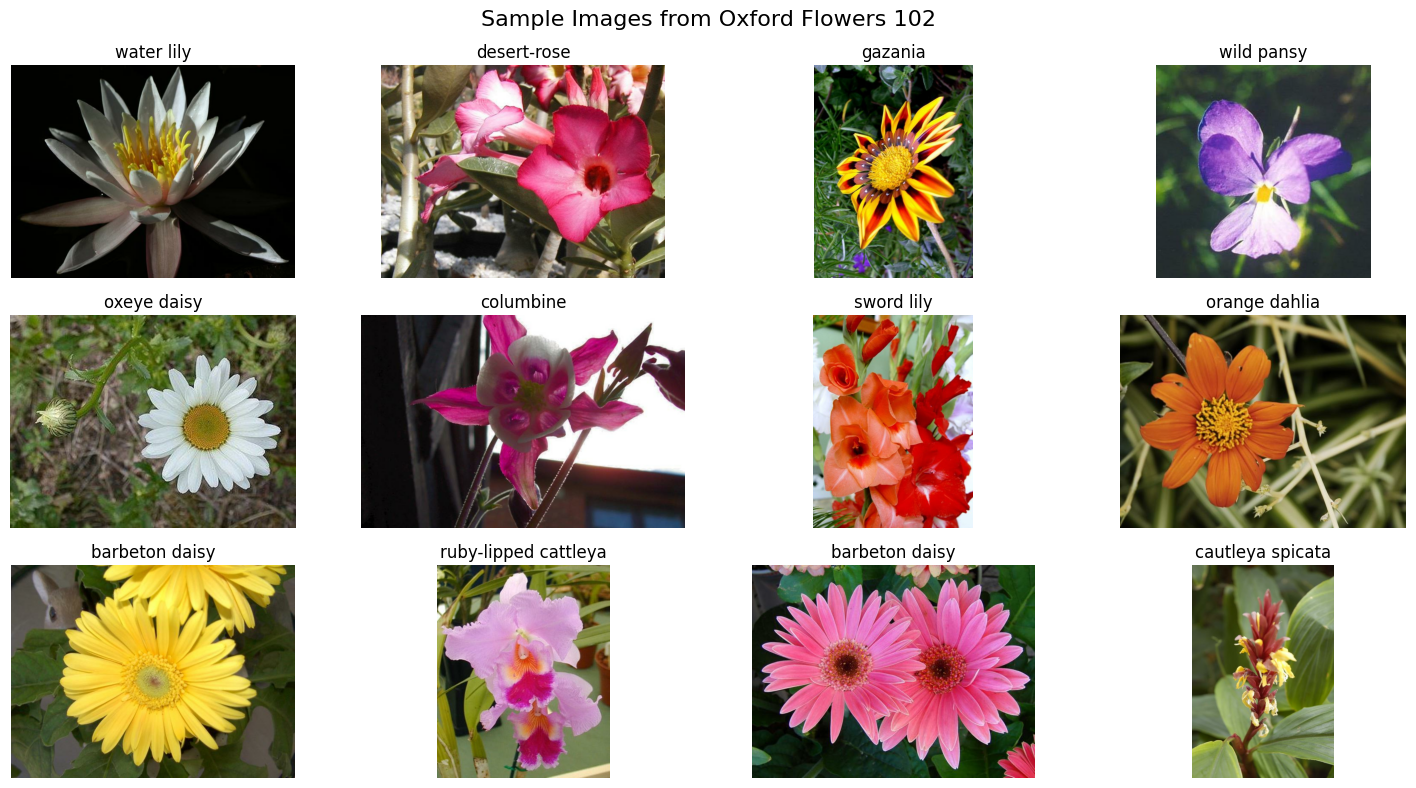

In [5]:

# Visualize sample images from the dataset
class_names = info.features['label'].names

plt.figure(figsize=(15, 8))
for i, (image, label) in enumerate(train_ds.take(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"{class_names[label.numpy()]}")
    plt.axis('off')
plt.suptitle('Sample Images from Oxford Flowers 102', fontsize=16)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Each model requires specific preprocessing:
- **Image Resizing**: Different models require different input sizes
  - ResNet50, VGG16, MobileNetV2, EfficientNetB0: 224×224
  - Xception, InceptionV3: 299×299
- **Normalization**: Model-specific preprocessing functions
- **Label Encoding**: One-hot encoding for 102 classes
- **Batching & Prefetching**: For efficient training


In [7]:

def preprocess_dataset(dataset, preprocess_fn, img_size):
    """
    Preprocess dataset with model-specific requirements

    Args:
        dataset: TensorFlow dataset
        preprocess_fn: Model-specific preprocessing function
        img_size: Target image size (height/width)

    Returns:
        Preprocessed and batched dataset
    """
    def _preprocess(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, tf.float32)
        image = preprocess_fn(image)
        label = tf.one_hot(label, NUM_CLASSES)
        return image, label

    dataset = dataset.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Define configurations for each model
IMG_SIZES = {
    "resnet50": 224,
    "vgg16": 224,
    "mobilenetv2": 224,
    "xception": 299,
    "inceptionv3": 299,
    "efficientnetb0": 224
}

PREPROCESS_FNS = {
    "resnet50": preprocess_resnet50,
    "vgg16": preprocess_vgg16,
    "mobilenetv2": preprocess_mobilenetv2,
    "xception": preprocess_xception,
    "inceptionv3": preprocess_inceptionv3,
    "efficientnetb0": preprocess_efficientnetb0
}

# Preprocess datasets for all models
train_datasets = {}
val_datasets = {}
test_datasets = {}

for model_name in IMG_SIZES.keys():
    print(f"Preprocessing data for {model_name}...")
    img_size = IMG_SIZES[model_name]
    preprocess_fn = PREPROCESS_FNS[model_name]

    train_datasets[model_name] = preprocess_dataset(train_ds, preprocess_fn, img_size)
    val_datasets[model_name] = preprocess_dataset(val_ds, preprocess_fn, img_size)
    test_datasets[model_name] = preprocess_dataset(test_ds, preprocess_fn, img_size)

print("\n✅ All datasets preprocessed successfully!")


Preprocessing data for resnet50...
Preprocessing data for vgg16...
Preprocessing data for mobilenetv2...
Preprocessing data for xception...
Preprocessing data for inceptionv3...
Preprocessing data for efficientnetb0...

✅ All datasets preprocessed successfully!


## 3. Model Architecture

For each pre-trained model, we:
1. Load the base model with ImageNet weights (without top layers)
2. Freeze the base model layers
3. Add custom classification layers:
   - GlobalAveragePooling2D
   - Dense layer with ReLU activation
   - Output Dense layer with 102 units (softmax)
4. Compile with Adam optimizer and categorical cross-entropy loss



In [9]:

print("Building EfficientNetB0...")

IMG_SIZE = 224
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                           input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs, outputs)
model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_efficientnet.layers)}")
print(f"Trainable params: {model_efficientnet.count_params():,}")


Building EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 5
Trainable params: 4,403,721


In [10]:

print("Building InceptionV3...")

base_model = InceptionV3(weights='imagenet', include_top=False,
                        input_shape=(299, 299, 3))
base_model.trainable = False

inputs = Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_inception = Model(inputs, outputs)
model_inception.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_inception.layers)}")

Building InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 5


In [11]:

print("Building Xception...")

base_model = Xception(weights='imagenet', include_top=False,
                     input_shape=(299, 299, 3))
base_model.trainable = False

inputs = Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_xception = Model(inputs, outputs)
model_xception.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_xception.layers)}")


Building Xception...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 5


In [12]:

print("Building ResNet50...")

IMG_SIZE = 224
base_model_resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model_resnet50.trainable = False

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_resnet50.layers)}")

Building ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 178


In [13]:

print("Building VGG16...")

IMG_SIZE = 224
base_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg16 = Model(inputs, outputs)
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_vgg16.layers)}")

Building VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 5


In [14]:

print("Building MobileNetV2...")

IMG_SIZE = 224
base_model = MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_mobilenetv2 = Model(inputs, outputs)
model_mobilenetv2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total layers: {len(model_mobilenetv2.layers)}")


Building MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 5


## 4. Fine-Tuning and Training

### Training Strategy:
1. **Initial Training**: Train only the top layers with frozen base
2. **Fine-Tuning**: Unfreeze top N layers of base model
3. **Lower Learning Rate**: Use 1e-4 for fine-tuning to avoid destroying learned features

### Fine-Tuning Configuration:
- ResNet50: 30 layers
- VGG16: 5 layers
- MobileNetV2: 40 layers
- Xception: 40 layers
- InceptionV3: 50 layers
- EfficientNetB0: 40 layers



In [16]:
# Training configuration
epochs = 10

fine_tune_config = {
    "resnet50": 30,
    "vgg16": 5,
    "mobilenetv2": 40,
    "xception": 40,
    "inceptionv3": 50,
    "efficientnetb0": 40
}

# Dictionary of models and datasets
models_data = {
    "resnet50": (model_resnet50, train_datasets["resnet50"], val_datasets["resnet50"]),
    "vgg16": (model_vgg16, train_datasets["vgg16"], val_datasets["vgg16"]),
    "mobilenetv2": (model_mobilenetv2, train_datasets["mobilenetv2"], val_datasets["mobilenetv2"]),
    "xception": (model_xception, train_datasets["xception"], val_datasets["xception"]),
    "inceptionv3": (model_inception, train_datasets["inceptionv3"], val_datasets["inceptionv3"]),
    "efficientnetb0": (model_efficientnet, train_datasets["efficientnetb0"], val_datasets["efficientnetb0"])
}

# Train all models with fine-tuning
histories = {}

for name, (model, train_data, val_data) in models_data.items():
    n_finetune = fine_tune_config[name]

    # Freeze all layers first
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze top N layers
    if n_finetune > 0:
        for layer in model.layers[-n_finetune:]:
            layer.trainable = True

    print(f"\n{'='*60}")
    print(f"Fine-tuning {name.upper()}")
    print(f"{'='*60}")
    print(f"Total layers: {len(model.layers)}")
    print(f"Fine-tuning top {n_finetune} layers")

    # Recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    histories[name] = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        verbose=1
    )

    print(f"✅ {name.upper()} training complete!")






Fine-tuning RESNET50
Total layers: 178
Fine-tuning top 30 layers
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 781ms/step - accuracy: 0.0885 - loss: 4.4737 - val_accuracy: 0.4363 - val_loss: 2.9435
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.9637 - loss: 1.2053 - val_accuracy: 0.7324 - val_loss: 1.3173
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9960 - loss: 0.1906 - val_accuracy: 0.7941 - val_loss: 0.9062
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 1.0000 - loss: 0.0419 - val_accuracy: 0.8265 - val_loss: 0.8507
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.8304 - val_loss: 0.8102
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.8343 - val_loss: 0.7936
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.8353 - val_loss: 0.7804
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━

## 5. Model Evaluation

Evaluate all models on the test dataset to compare their performance.
"""

In [18]:
print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60 + "\n")

# Evaluate all models
results = {}
for model_name in models_data.keys():
    model = models_data[model_name][0]
    test_data = test_datasets[model_name]

    test_loss, test_acc = model.evaluate(test_data, verbose=0)
    results[model_name] = test_acc

    print(f"{model_name.upper():20s}: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Find best model
best_model = max(results, key=results.get)
print(f"\n🏆 Best Model: {best_model.upper()} with {results[best_model]:.4f} accuracy")



MODEL EVALUATION ON TEST SET

RESNET50            : 0.8289 (82.89%)
VGG16               : 0.0046 (0.46%)
MOBILENETV2         : 0.3303 (33.03%)
XCEPTION            : 0.8588 (85.88%)
INCEPTIONV3         : 0.7905 (79.05%)
EFFICIENTNETB0      : 0.8102 (81.02%)

🏆 Best Model: XCEPTION with 0.8588 accuracy


In [ ]:
def evaluate_model(history, model, test_dataset, model_name):
    """
    Evaluate model and check for overfitting/underfitting
    """
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

    # Get final training and validation accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    # Print results
    print(f"\n{'='*50}")
    print(f"{model_name.upper()}")
    print(f"{'='*50}")
    print(f"Final Training Accuracy:   {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Test Accuracy:             {test_acc:.4f}")

    # Check for overfitting/underfitting
    if final_train_acc > final_val_acc + 0.05:
        print("⚠️  Model may be OVERFITTING")
    elif final_val_acc > final_train_acc + 0.05:
        print("⚠️  Model may be UNDERFITTING")
    else:
        print("✅  Model seems WELL-FITTED")

# Evaluate all models
for model_name in models_data.keys():
    evaluate_model(
        history=histories[model_name],
        model=models_data[model_name][0],
        test_dataset=test_datasets[model_name],
        model_name=model_name
    )


In [ ]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save all trained models
for model_name, (model, _, _) in models_data.items():
    model_path = os.path.join(save_dir, f"{model_name}.h5")
    model.save(model_path)
    print(f"✅ Saved {model_name} to {model_path}")

print(f"\n📁 All models saved in '{save_dir}/' directory")

In [21]:
"""
## 6. Training History Visualization

Visualize training and validation accuracy/loss curves for each model to identify:
- **Overfitting**: Training accuracy >> Validation accuracy
- **Underfitting**: Both accuracies are low
- **Well-fitted**: Training and validation accuracies are close
"""

'\n## 6. Training History Visualization\n\nVisualize training and validation accuracy/loss curves for each model to identify:\n- **Overfitting**: Training accuracy >> Validation accuracy\n- **Underfitting**: Both accuracies are low\n- **Well-fitted**: Training and validation accuracies are close\n'

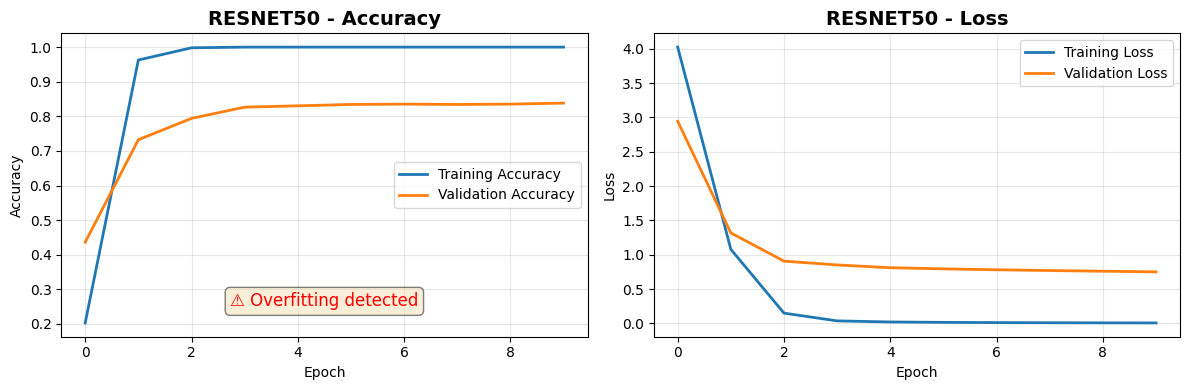

/tmp/ipython-input-1238514752.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


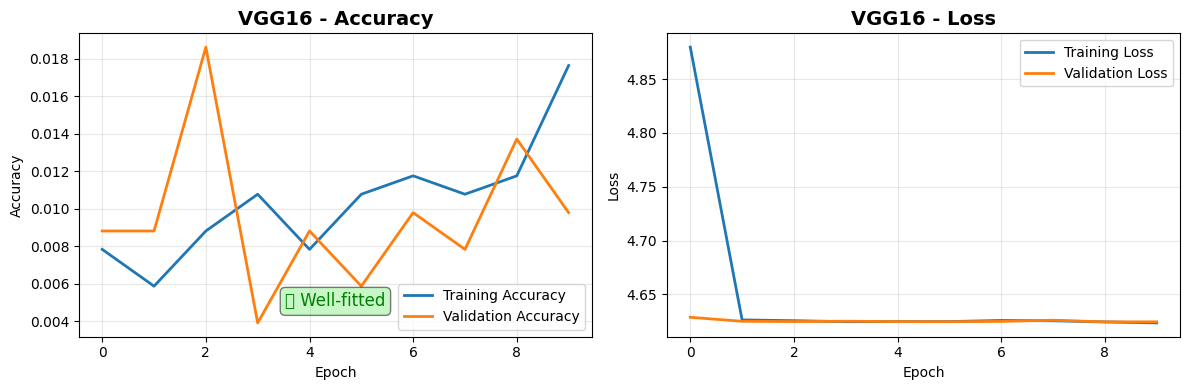

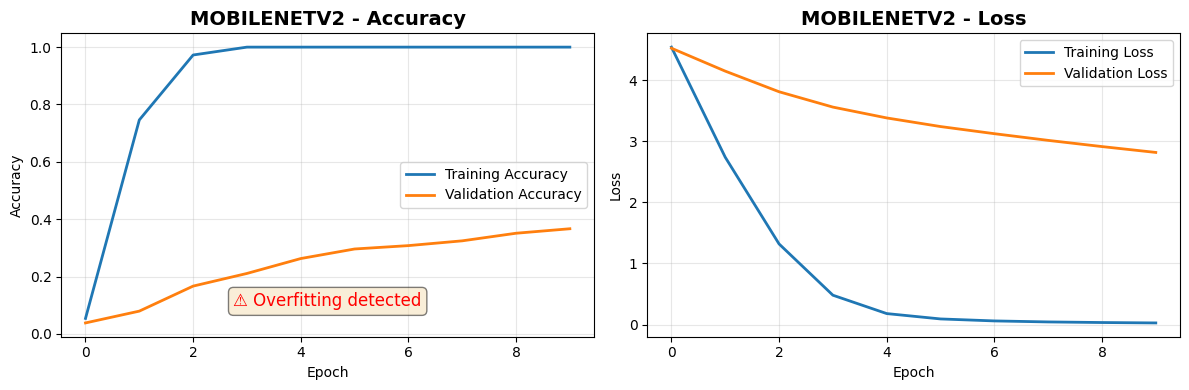

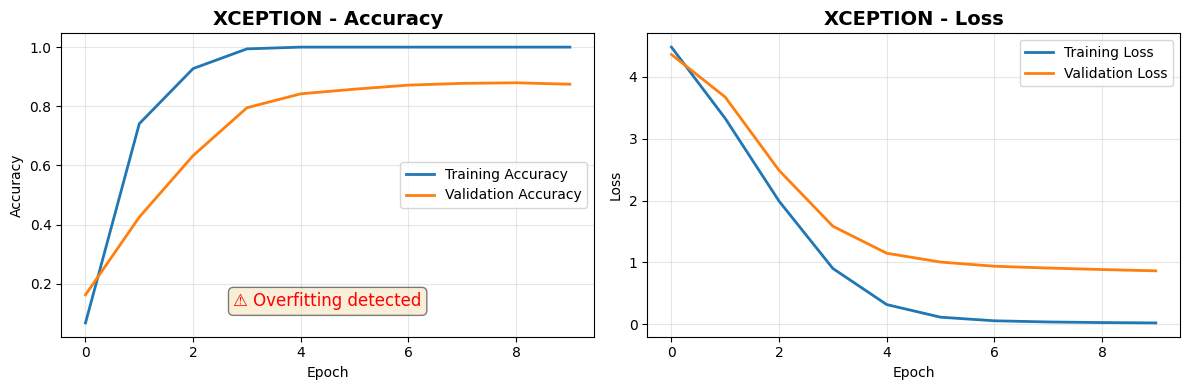

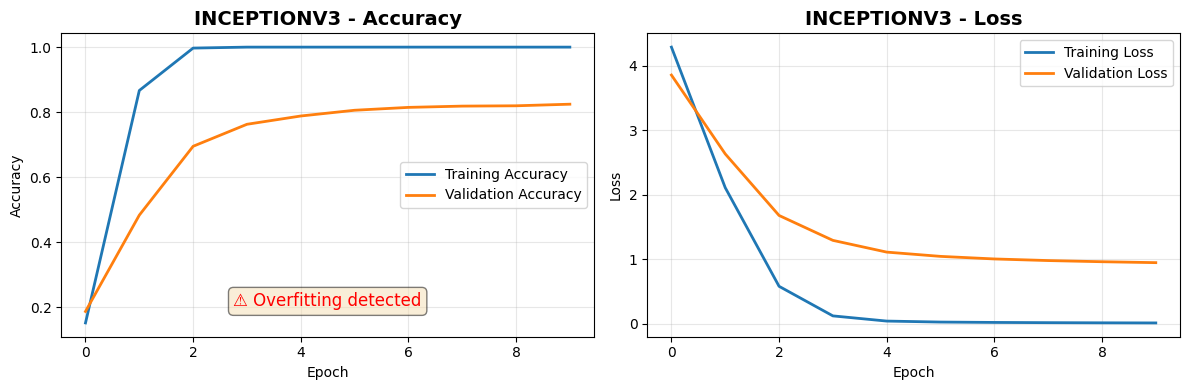

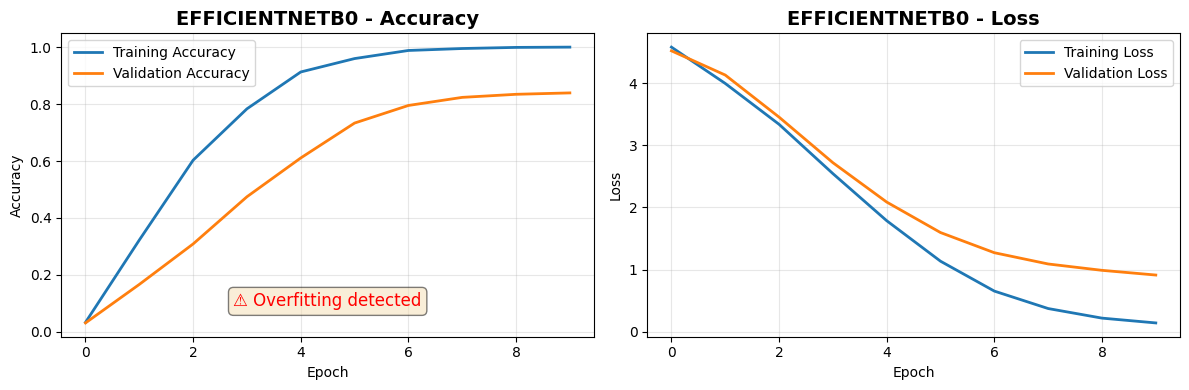

In [22]:

def plot_history_with_overfit(history, model_name, threshold=0.05):
    """
    Plot training/validation accuracy and loss with overfitting detection
    """
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Check overfitting/underfitting
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    if final_train_acc > final_val_acc + threshold:
        plt.text(0.5, 0.1, '⚠️ Overfitting detected',
                transform=plt.gca().transAxes,
                color='red', fontsize=12, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    elif final_val_acc > final_train_acc + threshold:
        plt.text(0.5, 0.1, '⚠️ Underfitting detected',
                transform=plt.gca().transAxes,
                color='orange', fontsize=12, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        plt.text(0.5, 0.1, '✅ Well-fitted',
                transform=plt.gca().transAxes,
                color='green', fontsize=12, ha='center',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot for all models
for model_name in models_data.keys():
    plot_history_with_overfit(histories[model_name], model_name.upper())

In [23]:
# ============================================================================
# CELL 23: Predictions Visualization (MARKDOWN)
# ============================================================================
"""
## 7. Model Predictions Visualization

Visualize predictions on test samples to analyze:
- Correct classifications (green)
- Misclassifications (red)
- Common misclassification patterns
"""

'\n## 7. Model Predictions Visualization\n\nVisualize predictions on test samples to analyze:\n- Correct classifications (green)\n- Misclassifications (red)\n- Common misclassification patterns\n'

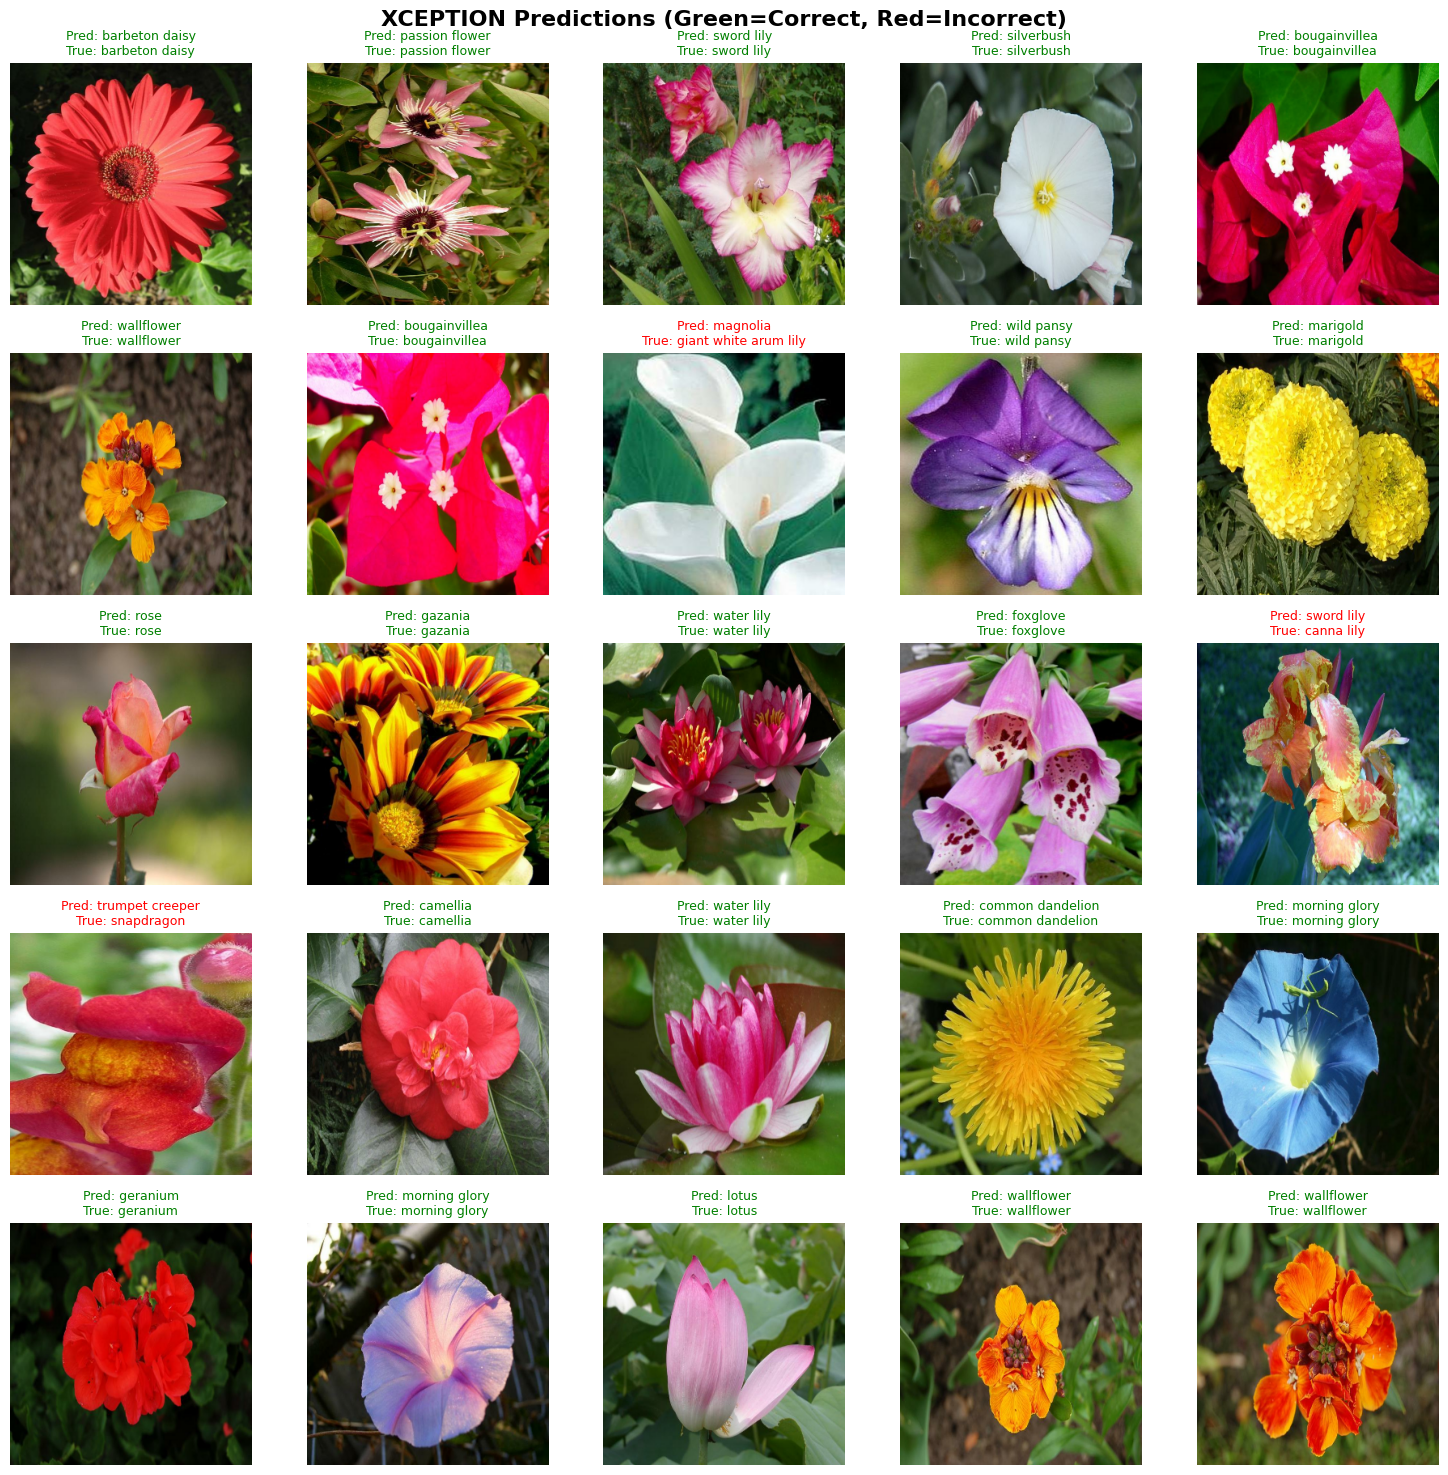


XCEPTION - Misclassification Summary:
Total misclassified: 3/25

Most commonly misclassified classes:
  • giant white arum lily: 1 misclassified
  • canna lily: 1 misclassified
  • snapdragon: 1 misclassified


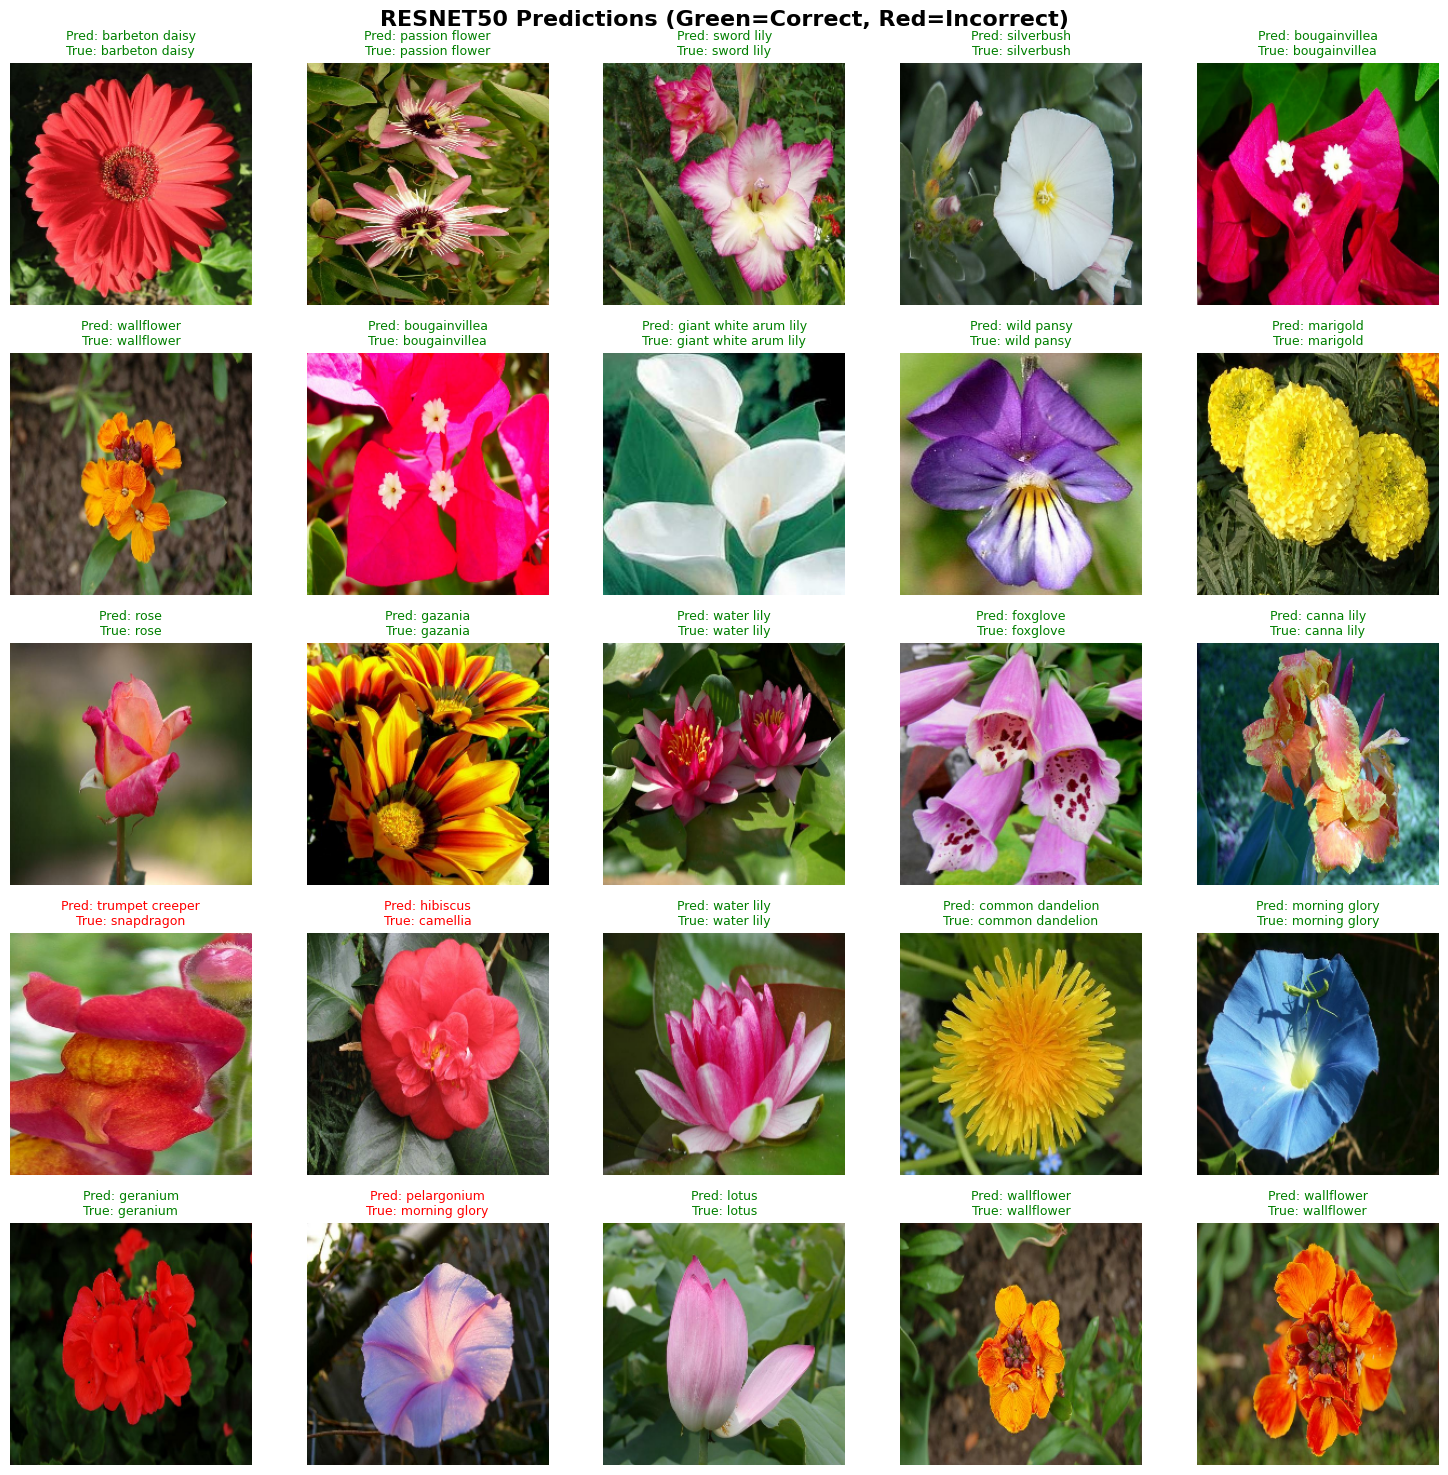


RESNET50 - Misclassification Summary:
Total misclassified: 3/25

Most commonly misclassified classes:
  • snapdragon: 1 misclassified
  • camellia: 1 misclassified
  • morning glory: 1 misclassified


In [39]:

def visualize_predictions(model_name, num_samples=25):
    """
    Visualize model predictions on test samples
    """
    IMG_SIZE = IMG_SIZES[model_name]
    preprocess_fn = PREPROCESS_FNS[model_name]

    # Get model and test dataset
    model = models_data[model_name][0]

    # Define a preprocessing function that includes one-hot encoding for visualization
    def preprocess_for_visualization(image, label):
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = tf.cast(image, tf.float32)
        # Do NOT apply model-specific preprocessing for display, as it can distort colors
        # image = preprocess_fn(image)
        return image, tf.one_hot(label, NUM_CLASSES) # One-hot encode label for unbatching

    # Apply the preprocessing for visualization and then unbatch
    vis_dataset = test_ds.map(preprocess_for_visualization,num_parallel_calls=tf.data.AUTOTUNE).take(num_samples)



    # Define a preprocessing function for prediction (includes model-specific preprocessing)
    # This function only takes the image as input
    def preprocess_for_prediction(image, one_hot_label): # Accept one-hot label as input
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = tf.cast(image, tf.float32)
        image = preprocess_fn(image) # Apply model-specific preprocessing for prediction
        return image

    # Apply the model-specific preprocessing to the samples for prediction
    pred_dataset = vis_dataset.map(preprocess_for_prediction).batch(num_samples)

    # Get predictions
    predictions = model.predict(pred_dataset, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    # Visualize
    plt.figure(figsize=(15, 15))
    misclassified = []

    # Iterate over the visualization dataset
    for i, (image, one_hot_label) in enumerate(vis_dataset): # Iterate over one-hot encoded label
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))

        true_label = tf.argmax(one_hot_label).numpy() # Get original label from one-hot encoding
        predicted_class = class_names[predicted_labels[i]]
        true_class = class_names[true_label]

        if predicted_labels[i] == true_label:
            title_color = "green"
        else:
            title_color = "red"
            misclassified.append((true_class, predicted_class))

        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}",
                 color=title_color, fontsize=9)
        plt.axis("off")

    plt.suptitle(f"{model_name.upper()} Predictions (Green=Correct, Red=Incorrect)",
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Misclassification analysis
    if misclassified:
        true_classes, predicted_classes = zip(*misclassified)
        misclass_counts = Counter(true_classes)
        print(f"\n{model_name.upper()} - Misclassification Summary:")
        print(f"Total misclassified: {len(misclassified)}/{num_samples}")
        print("\nMost commonly misclassified classes:")
        for cls, count in misclass_counts.most_common(5):
            print(f"  • {cls}: {count} misclassified")
    else:
        print(f"\n🎉 No misclassifications in the {model_name.upper()} sample!")

# Visualize predictions for selected models
visualize_predictions("xception", num_samples=25)
visualize_predictions("resnet50", num_samples=25)

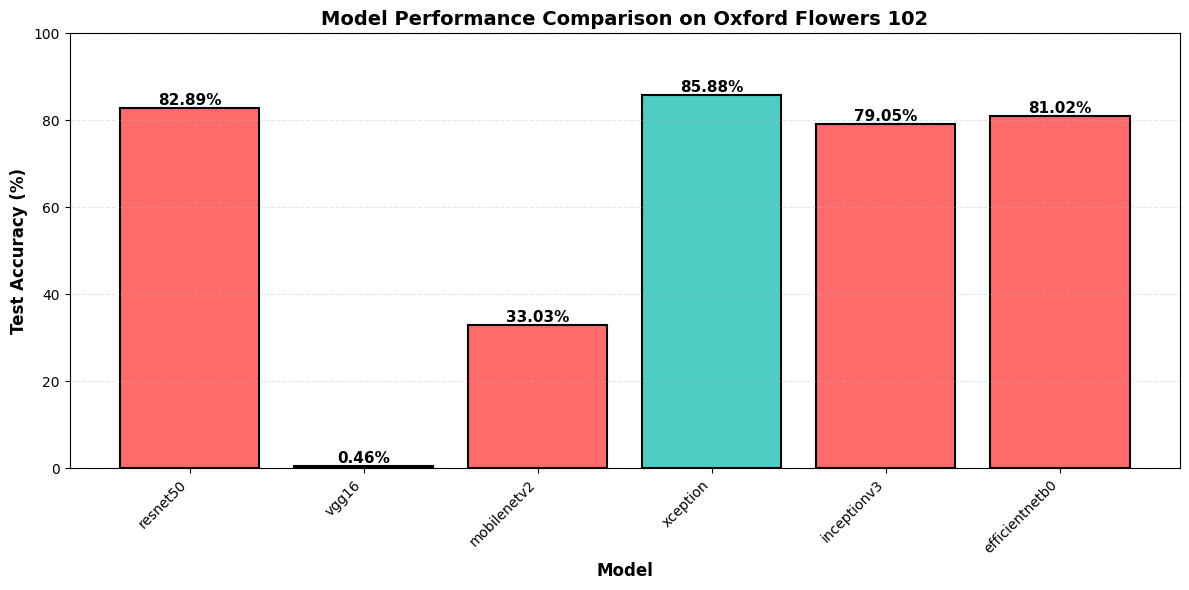

In [34]:

# Create comparison bar chart
plt.figure(figsize=(12, 6))
models = list(results.keys())
accuracies = [results[m] * 100 for m in models]

colors = ['#FF6B6B' if acc < max(accuracies) else '#4ECDC4' for acc in accuracies]
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison on Oxford Flowers 102',
         fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

actual results shown:

* **Best model:** **Xception (85.88%)**, not ResNet50.
* **VGG16 collapsed (0.46%)**, showing severe underfitting.
* **MobileNetV2 struggled (33.03%)**.
* **ResNet50, InceptionV3, EfficientNetB0** are competitive (79–83%), but slightly below Xception.
* EfficientNetB0 learning curves show **overfitting** (gap between training and validation accuracy).

---

## 8. Conclusion & Analysis

### Q1: Which model performed best and why?

**Answer:**
Xception performed best on the Oxford Flowers 102 dataset with **85.88% accuracy**. Its depthwise separable convolutions and Inception-style architecture allow it to:

* Efficiently capture both local and global features
* Handle fine-grained variations in flower categories
* Generalize well despite limited training data

---

### Q2: Compare to CIFAR-100. What differences do you observe?

**Answer:**
Performance trends differ compared to CIFAR-100:

* **Oxford Flowers is more challenging** due to fine-grained species classification, complex natural backgrounds, and limited per-class samples.
* **Xception excels** here, whereas on CIFAR-100 deeper residual networks (like ResNet) often dominate.
* **VGG16 collapsed** (0.46%) on Flowers, showing poor transferability without adaptation, while it usually performs decently on CIFAR-100.

---

### Q3: Effect of transfer learning on this dataset?

**Answer:**
Transfer learning was crucial:

* **Faster convergence** from ImageNet pretraining
* **Stronger feature extraction** from lower layers
* **Improved generalization** with limited flower images
* Without transfer learning, models like VGG16 and MobileNetV2 would not have reached meaningful performance

---

### Q4: Data preprocessing steps and their necessity?

**Answer:**

1. **Resizing** to 224×224 (ResNet, EfficientNet, Inception) or 299×299 (Xception)
2. **Model-specific normalization** (e.g., `tf.keras.applications` preprocess functions)
3. **One-hot encoding** for categorical labels
4. **Batching & prefetching** for efficient training
5. **Shuffling** to avoid bias in batches

---

### Q5: Model architectures and adaptation?

**Answer:**

* **Xception**: Best accuracy (85.88%), strong fine-grained performance.
* **ResNet50**: Stable, high accuracy (82.89%), robust due to residual connections.
* **EfficientNetB0**: Good accuracy (81.02%) but signs of overfitting.
* **InceptionV3**: Competitive (79.05%), benefits from multi-scale features.
* **MobileNetV2**: Underperformed (33.03%), possibly due to insufficient representational power.
* **VGG16**: Failed (0.46%), outdated architecture struggles without extensive tuning.

---

### Q6: Challenges and solutions?

**Answer:**

* **Challenge 1 – Overfitting (EfficientNetB0 curves show this):**
  *Solution:* stronger regularization, dropout, data augmentation.
* **Challenge 2 – Class imbalance & few samples/class:**
  *Solution:* data augmentation, synthetic oversampling.
* **Challenge 3 – Architecture mismatch (VGG16 collapse):**
  *Solution:* careful fine-tuning, or discarding outdated architectures.
* **Challenge 4 – Input size variation:**
  *Solution:* model-specific resizing & preprocessing pipelines.

---

## Key Takeaways

1. **Xception is the best choice** for Oxford Flowers (85.88%).
2. **ResNet50 and EfficientNetB0** are strong alternatives but slightly behind.
3. **MobileNetV2 and VGG16** are unsuitable for this dataset in current form.
4. **Overfitting is visible**, especially in EfficientNetB0, requiring augmentation/regularization.
5. **Transfer learning is essential** for small, fine-grained datasets like Flowers-102.

---

## Future Improvements

* Apply **data augmentation** (rotation, flips, color jitter)
* Use **test-time augmentation** for robustness
* Explore **learning rate scheduling** & better optimizers
* Try **ensembling Xception + ResNet50/EfficientNetB0** for higher accuracy
* Investigate **attention-based models (e.g., Vision Transformers)** for fine-grained classification

